
## Radio Pulmonaires pour l'analyse du COVID19
### DataScientest : Bootcamp DataScientist
Octobre 2024

#### On commence par importer les packages qui seront utiles
(Il faut les installer préalablement opencv-python  -> cv2
read_excel de pandas a une dépendance vers openpyxl)

In [31]:
# Import des packages

# Naviguer dans les répertoire

import os

## Data preprocessing
import numpy as np
import pandas as pd 
import string

# Data_viz

import seaborn as sns
import matplotlib.pyplot as plt

# Gestion des images
import cv2


# On indique le répertoire de travail

path = r"C:\Users\Inrae\Documents\Projet_Data_Science\COVID-19_Radiography_Dataset"



Les données ont été téléchargées préalablement. 
Elles sont dispo sous : https://www.kaggle.com/code/ahmedtronic/covid-19-radiology-vgg19-f1-score-95

Il y a trois dossiers (COVID, Lung_Opacity et Normal) contenant chacun plusieurs milliers d'images et les masques associés
Le fichier excel donne des informations sur les metadaonnées : url de la source

Il faudra les importer, les annoter en fonction de leur dossier initial, les préprocesser pour pouvoir les exploiter ensuite en classification

# On explore pour une image


Le format de l'image est :  (299, 299, 3)


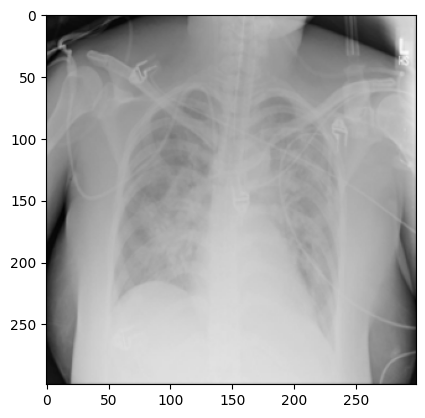

In [21]:
img_color = cv2.imread(r"./COVID-19_Radiography_Dataset\Lung_Opacity\images\Lung_Opacity-10.png",cv2.IMREAD_COLOR)

print("Le format de l'image est : ", img_color.shape)

plt.imshow(img_color)


Le format de l'image est :  (299, 299)


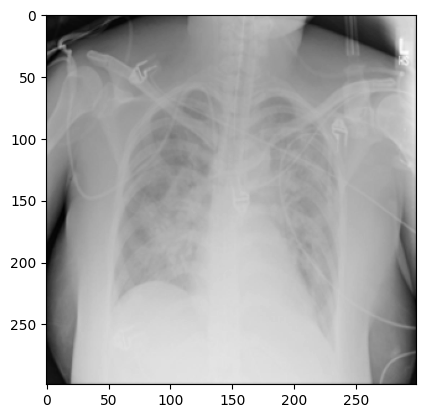

In [25]:

img_grey = cv2.imread(r"./COVID-19_Radiography_Dataset\Lung_Opacity\images\Lung_Opacity-10.png",cv2.IMREAD_GRAYSCALE)

print("Le format de l'image est : ", img_grey.shape)

plt.imshow(img_grey,cmap="gray")


#Visuellement il semble y avoir peu de différence entre l'image en nuance de gris ou en couleur, on part dans un premier temps sur les données en gris


Le format du masque est :  (256, 256)


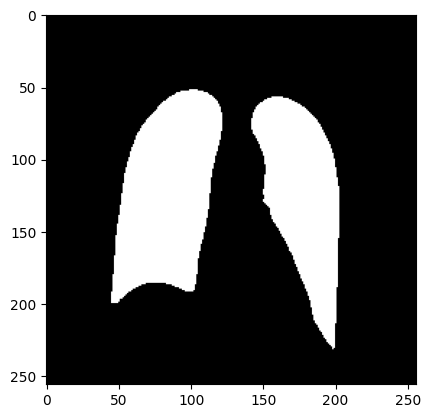

In [23]:
 # On lit le masque correspondant et on l'applique

mask_grey = cv2.imread(r"./COVID-19_Radiography_Dataset\Lung_Opacity\masks\Lung_Opacity-10.png",cv2.IMREAD_GRAYSCALE)

print("Le format du masque est : ", mask_grey.shape)

plt.imshow(mask_grey,cmap="gray")


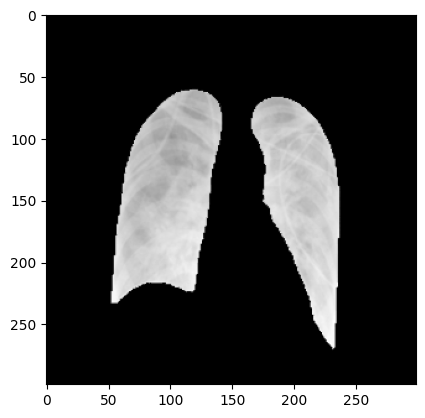

In [28]:

# On applique le masque 

# On redimensionne le masque au format de l image car l'un est en 256*256 l'autre en 299*299

mask_grey2 = cv2.resize(mask_grey, dsize = img_grey.shape[:2])

# 
masked_image = cv2.bitwise_and(img_grey, mask_grey2) # pour masquer mon_image

plt.imshow(masked_image,cmap="gray")

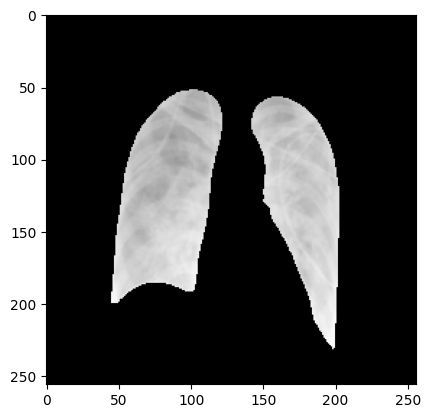

In [30]:
# On essaye pour voir s'il ne vaut pas mieux redimensionner l'image 

img_grey2 = cv2.resize(img_grey, dsize = mask_grey.shape[:2])

# 
masked_image2 = cv2.bitwise_and(img_grey2, mask_grey) # pour masquer mon_image

plt.imshow(masked_image2,cmap="gray")

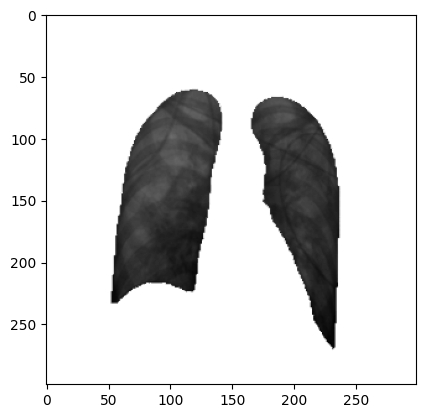

In [47]:
# On applique une normalisation de gauss

gauss_image = cv2.GaussianBlur(masked_image, ksize = (3,3), sigmaX=0.2)

plt.imshow(gauss_image,cmap="gray")

# Peut être serait il utile de passer en negatif
# gauss_image_neg = 255 - gauss_image
# plt.imshow(gauss_image_neg,cmap="gray")

# A creuser pour s avoir s il serait utile d'utilise erode pour supprimer les electrodes
# ou threshold pour supprimer ce qui est trop blanc ?

Il faut a present stocker l image dans un vecteur

In [79]:
# On la transforme en format 

a = np.arange(6).reshape((3, 2))

print(a)

a.reshape(6)

# On transforme en vecteur 
gauss_vector = gauss_image.reshape(1,gauss_image.shape[0]*gauss_image.shape[1])

gauss_df  = pd.DataFrame(gauss_vector)

gauss_df["id"] = ("lung_opacity10")
gauss_df["type"] = ("lung_opacity")
#gauss_df["id","type"]= ("lung opacity"

gauss_df.set_index("id")

#gauss_line.append([gauss_vector])

gauss_df


[[0 1]
 [2 3]
 [4 5]]


,0,1,2,3,4,5,6,7,8,9,...,89393,89394,89395,89396,89397,89398,89399,89400,id,type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,lung_opacity10,lung_opacity


In [147]:
# On stocle le df de lung opacity

df_lung_opacity = df

# On va travailler sur les 500 premieres images de chaque categorie

## On importe les images en les preprocessant
### Application du masque
### Application d'un filtre gaussien
### On transforme le tout en dataset


In [2]:
df  = None

for type in  ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"] :
    print(type)
    list = os.listdir(os.path.join("./COVID-19_Radiography_Dataset",type,"images"))
    #print(list[:10])
    for filename in list :
        #print(type,filename,os.path.join("./COVID-19_Radiography_Dataset",type,"images",filename))
        img = cv2.imread(os.path.join("./COVID-19_Radiography_Dataset",type,"images",filename),cv2.IMREAD_GRAYSCALE) # import de l'image
        mask = cv2.imread(os.path.join("./COVID-19_Radiography_Dataset",type,"masks",filename),cv2.IMREAD_GRAYSCALE) # import du masque 
        mask2 = cv2.resize(mask, dsize = img.shape[:2])  # pour remettre les dimensions du masque à celle de l'image
        masked_img = cv2.bitwise_and(img, mask2) # pour masquer l'image
        #plt.imshow(masked_img,cmap="gray")
        gauss_img = cv2.GaussianBlur(masked_img, ksize = (3,3), sigmaX=0.2)
        gauss_df = pd.DataFrame(gauss_img.reshape(1,gauss_img.shape[0]*gauss_img.shape[1]),index = [filename.split(".")[0]])
        #gauss_df["id"] = filename.split(".")[0]
        gauss_df["type"] = type
        
        if df is None :
           df  = gauss_df
        
        else:
        
           df = pd.concat([df, gauss_df])


    

Lung_Opacity
COVID
Normal
Viral_Pneumonia


# On importe les metadonnées 

In [152]:
# ! pip install openpyxl

all_meta = None

path

for type in  ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"] :
    print(type)
    namefile= type + ".metadata" + ".xlsx"
    file = os.path.join(path,namefile)
    print(file)
    meta = pd.read_excel(file)
    if all_meta is None :
        all_meta  = meta
    else:
        all_meta = pd.concat([all_meta, meta])

# On recree une colonne types et une colonne numéro
# Car normal est ici ecrit en majuscule

all_meta["TYPE"] = all_meta["FILE NAME"].str.split("-", expand=True)[0]
all_meta["num"] = all_meta["FILE NAME"].str.split("-", expand=True)[1]


Lung_Opacity
C:\Users\Inrae\Documents\Projet_Data_Science\COVID-19_Radiography_Dataset\Lung_Opacity.metadata.xlsx
COVID
C:\Users\Inrae\Documents\Projet_Data_Science\COVID-19_Radiography_Dataset\COVID.metadata.xlsx
Normal
C:\Users\Inrae\Documents\Projet_Data_Science\COVID-19_Radiography_Dataset\Normal.metadata.xlsx
Viral_Pneumonia
C:\Users\Inrae\Documents\Projet_Data_Science\COVID-19_Radiography_Dataset\Viral_Pneumonia.metadata.xlsx


,FILE NAME,FORMAT,SIZE,URL,TYPE,num
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Lung_Opacity,1
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Lung_Opacity,2
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Lung_Opacity,3
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Lung_Opacity,4
4,Lung_Opacity-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,Lung_Opacity,5


<class 'pandas.core.frame.DataFrame'>
Index: 21165 entries, 0 to 1344
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FILE NAME  21165 non-null  object
 1   FORMAT     21165 non-null  object
 2   SIZE       21165 non-null  object
 3   URL        21165 non-null  object
 4   TYPE       21165 non-null  object
 5   num        21165 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


None

URL
rnsa                   14863
pneumonia-chestxray     2686
bimcv                   2474
CXNet                    400
eurorad                  258
ml-workgroup             183
covid-chestxray          182
senza                    119
Name: count, dtype: int64
TYPE
Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: count, dtype: int64


,FORMAT,SIZE,URL,TYPE,num
FILENAME,,,,,
Lung_Opacity-1,PNG,256*256,rnsa,Lung_Opacity,1
Lung_Opacity-2,PNG,256*256,rnsa,Lung_Opacity,2
Lung_Opacity-3,PNG,256*256,rnsa,Lung_Opacity,3
Lung_Opacity-4,PNG,256*256,rnsa,Lung_Opacity,4
Lung_Opacity-5,PNG,256*256,rnsa,Lung_Opacity,5


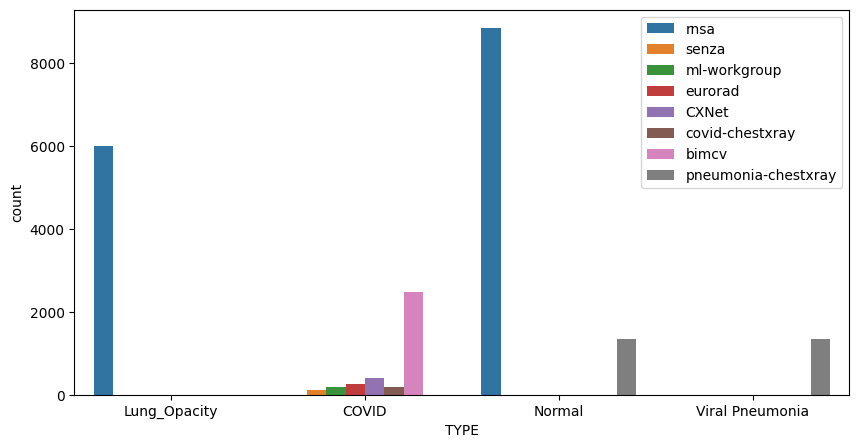

In [153]:
# On explore les metadata
display(all_meta.head())
display(all_meta.info())

# On affiche les nombres d occurences
all_meta["FORMAT"].value_counts()
all_meta["SIZE"].value_counts()
all_meta["URL"].value_counts()
all_meta["TYPE"].value_counts()

# On renomme la variable URL
all_meta.replace({
"https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data" : "rnsa",
"https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia" : "pneumonia-chestxray",                     
"https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711"  : "bimcv",
"https://github.com/armiro/COVID-CXNet" : "CXNet",
"https://eurorad.org" : "eurorad",                                                            
"https://github.com/ml-workgroup/covid-19-image-repository/tree/master/png"  : "ml-workgroup",
"https://github.com/ieee8023/covid-chestxray-dataset" : "covid-chestxray",
"https://sirm.org/category/senza-categoria/covid-19/" : "senza",
"NORMAL" : "Normal"
},
inplace = True
)

print(all_meta["URL"].value_counts())

print(all_meta["TYPE"].value_counts())

# On remet un nom coherent

all_meta["FILENAME"] = all_meta["TYPE"] +  "-" +  all_meta["num"]

all_meta =  all_meta.drop("FILE NAME", axis=1)
all_meta = all_meta.set_index("FILENAME")

display(all_meta.head())

# On verifie une eventuelle confusion entre url et type

pd.crosstab(all_meta["URL"], all_meta["TYPE"])

# On fait un comptage du nombre de données par url et par type
plt.figure(figsize=(10,5))
sns.countplot(data=all_meta,x="TYPE", hue="URL")
plt.legend(loc='best')


In [170]:
# On fusionne les metadata avec les data

all = all_meta.merge(right=df, how= "inner", left_index=True, right_index=True)

# On supprime type qui se retrouve en doublon
all = all.drop("type",axis=1)

display(all.head())

# On exporte le jeu de données complets
#all.to_csv("radio_tab.csv") 


,FORMAT,SIZE,URL,TYPE,num,0,1,2,3,4,...,89391,89392,89393,89394,89395,89396,89397,89398,89399,89400
Lung_Opacity-1,PNG,256*256,rnsa,Lung_Opacity,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-2,PNG,256*256,rnsa,Lung_Opacity,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-3,PNG,256*256,rnsa,Lung_Opacity,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-4,PNG,256*256,rnsa,Lung_Opacity,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-5,PNG,256*256,rnsa,Lung_Opacity,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


8 ['rnsa' 'senza' 'ml-workgroup' 'eurorad' 'CXNet' 'covid-chestxray' 'bimcv'
 'pneumonia-chestxray']


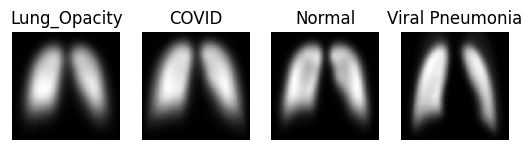

In [162]:
# # On enleve les variables descriptives

X = all.loc[:,0:]
y = all.TYPE


# # On fait une moyenne par type 

i=1
for i in range(4) :
    # Sélection des lignes de X_train correspondant au label i
    type = ["Lung_Opacity","COVID","Normal","Viral Pneumonia"][i]
    t = X[y == type]
    # Calcul de l'image moyenne
    moy_img = t.mean(axis=0)
    img =  moy_img.values.reshape(299,299)
    # Affichage de l'image dans le i+1-ème emplacement d'une grille de figures
    # à 2 lignes et 2 colonnes. 
    #plt.figure(figsize=(20,20))  
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(img, cmap="gray", interpolation='None')
    plt.title(type)
    #print(img)
# img



8 ['rnsa' 'senza' 'ml-workgroup' 'eurorad' 'CXNet' 'covid-chestxray' 'bimcv'
 'pneumonia-chestxray']


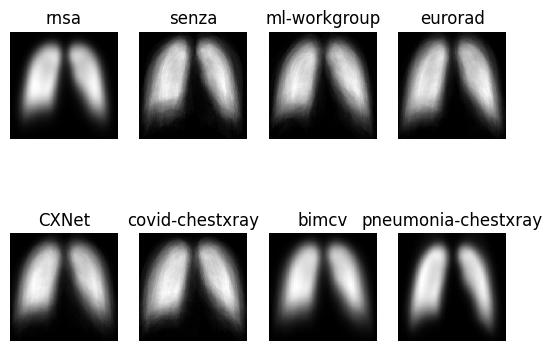

In [169]:

# # On fait une moyenne par source 
N = all.URL.nunique()
list = all.URL.unique()
source = all.URL

print(N, list)
i=1
for i in range(all.URL.nunique()) :
    # Sélection des lignes de X_train correspondant au label i
    url = all.URL.unique()[i]
    t = X[source == url]
    # Calcul de l'image moyenne
    moy_img = t.mean(axis=0)
    img =  moy_img.values.reshape(299,299)
    # Affichage de l'image dans le i+1-ème emplacement d'une grille de figures
    # à 2 lignes et 2 colonnes. 
    #plt.figure(figsize=(20,20))  
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img, cmap="gray", interpolation='None')
    plt.title(url)
    #print(img)
# img


#y.value_counts()
# plt.imshow(moy_img, cmap="gray", interpolation='None')

## On supprime les variables identiques pour tout le monde

In [171]:

#display(data.describe())

# On voit si on peut eliminer les colonnes non variables
data = df.loc[:, (df != df.iloc[0]).any()] 

print("On elimine", df.shape[1] - data.shape[1], "variables identiques pour tous les échantillons")
# ça ne vaut donc pas réellement le coup...




On elimine 1321 variables identiques pour tous les échantillons


## Nombre de données par catégories, moyennes et écart-type

Moyenne des valeurs par catégorie


type
COVID              27.968005
Lung_Opacity       24.731899
Normal             24.792048
Viral_Pneumonia    27.617663
dtype: float64

Ecart type des moyennes par catégorie


type
COVID              30.679016
Lung_Opacity       29.731666
Normal             30.406241
Viral_Pneumonia    36.399139
dtype: float64

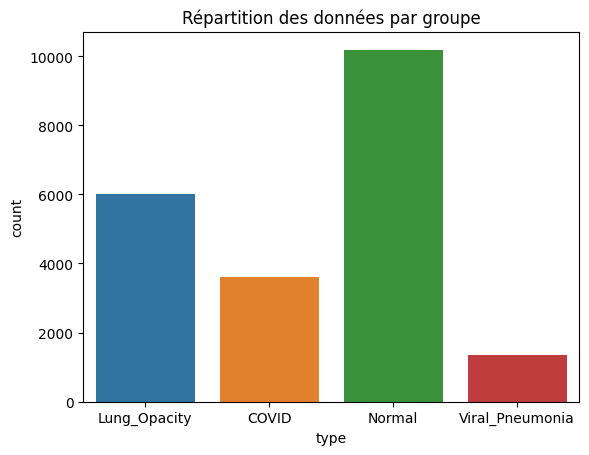

In [179]:
# On compte le nombre d'occurrence par groupe

sns.countplot(data=data,x="type",hue="type")
plt.title("Répartition des données par groupe")

# On fait la moyenne des valeurs et écart type par groupe
print("Moyenne des valeurs par catégorie")
display(data.groupby("type").mean().mean(axis=1))
print("Ecart type des moyennes par catégorie")
display(data.groupby("type").mean().std(axis=1))


## Visualiser une différence dans les valeurs des différents pixels selon les catégories
On trace un graph de la moyenne par pixel par groupe

In [173]:
# On essaye de tracer un graph de la moyenne par pixel par groupe

data_grouped = data.groupby("type").agg("mean")

data_grouped.head()

# On pourrait tracer le graph en bouclant variable par variable mais c'est très long !!! 
# # Tracer le graphique
# fig, ax = plt.subplots()
# for col in data_grouped.columns[1:]:
#     ax.plot(data_grouped['type'], data_grouped[col], marker='o', label=col)

# ax.set_xlabel('Categorie')
# ax.set_ylabel('Moyenne')
# ax.set_title('Moyennes de la valeur par Catégorie')
# ax.legend()
# plt.show()


,8,9,10,11,12,13,14,15,16,17,...,89390,89391,89392,89393,89394,89395,89396,89397,89398,89399
type,,,,,,,,,,,,,,,,,,,,,
COVID,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.386892,0.404591,0.296737,0.290653,0.228153,0.194414,0.194967,0.108960,0.074945,0.037611
Lung_Opacity,0.010645,0.014138,0.01314,0.012641,0.012641,0.012974,0.013307,0.01314,0.012475,0.011976,...,0.148536,0.123253,0.073686,0.075682,0.076846,0.032934,0.030772,0.031271,0.000000,0.000000
Normal,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.057987,0.044447,0.036107,0.024333,0.024627,0.013344,0.007849,0.000000,0.000000,0.000000
Viral_Pneumonia,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.086245,0.095167,0.000000,0.000000,0.028253,0.026766,0.029740,0.037918,0.000000,0.000000


,level_0,type,0
0,8,COVID,0.000000
1,8,Lung_Opacity,0.010645
2,8,Normal,0.000000
3,8,Viral_Pneumonia,0.000000
4,9,COVID,0.000000


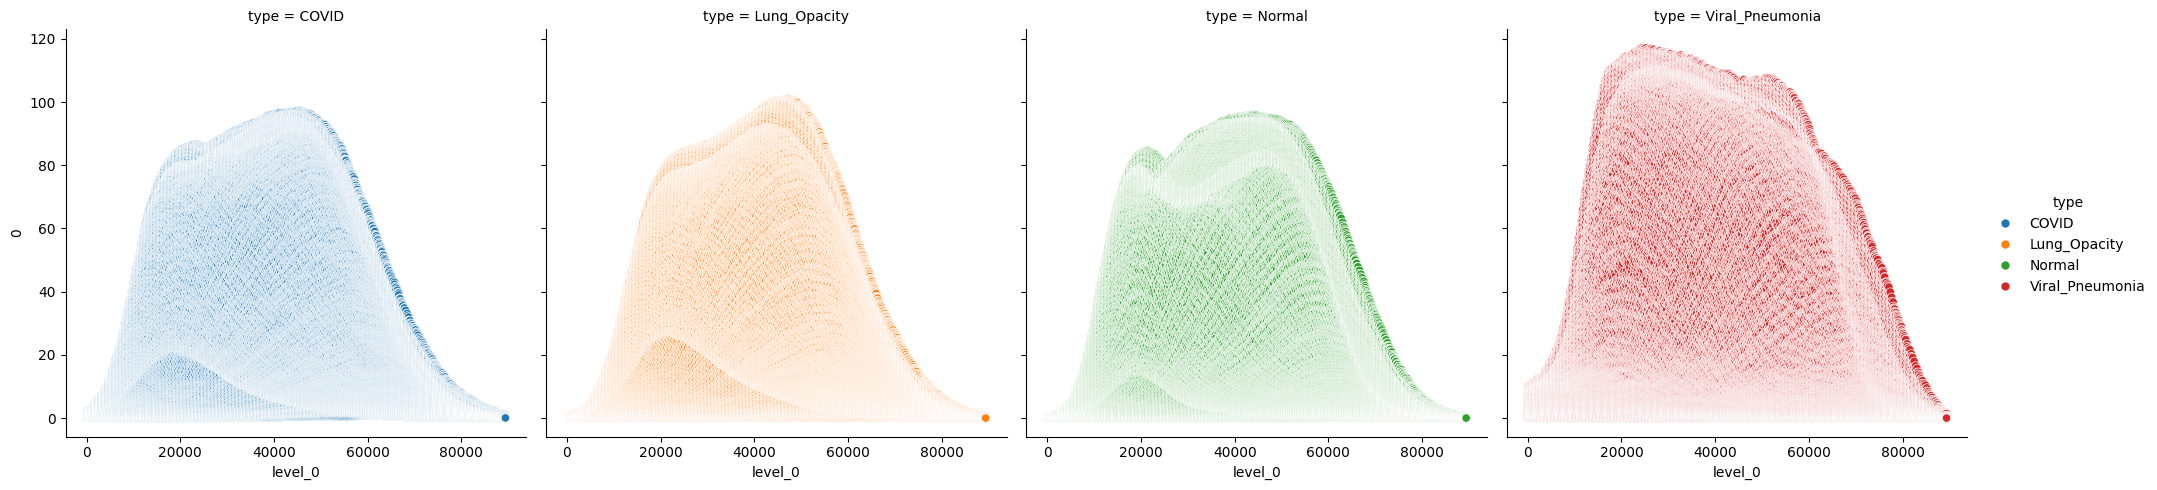

In [174]:
# On fait un unstack et on affiche le graph

group2 = data_grouped.unstack().reset_index()

# print(group2.columns,group2.shape)

display(group2.head())

sns.relplot(data=group2,x="level_0", y= 0, col='type',hue="type")


On visualise sous forme de boxplot

In [175]:
# Autre option on transpose ce qui permet de gérer les données plus facilement
moyenne = data_grouped.transpose()

display(moyenne.head())

type,COVID,Lung_Opacity,Normal,Viral_Pneumonia
8,0.0,0.010645,0.0,0.0
9,0.0,0.014138,0.0,0.0
10,0.0,0.013140,0.0,0.0
11,0.0,0.012641,0.0,0.0
12,0.0,0.012641,0.0,0.0


type,COVID,Lung_Opacity,Normal,Viral_Pneumonia
count,88080.000000,88080.000000,88080.000000,88080.000000
mean,27.968005,24.731899,24.792048,27.617663
std,30.679016,29.731666,30.406241,36.399139
min,0.000000,0.000000,0.000000,0.000000
25%,1.916690,1.042914,0.464752,0.431970
50%,13.717920,9.379325,7.130838,7.613011
75%,51.062362,43.414047,49.398401,48.666543
max,97.277378,100.970393,95.911794,117.130112


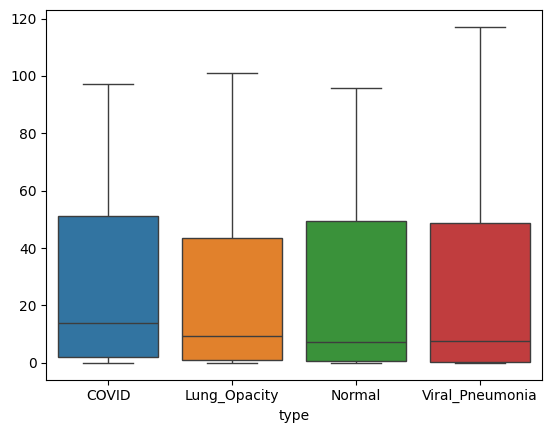

In [176]:
sns.boxplot(moyenne)

display(moyenne.describe())

<Axes: xlabel='type'>

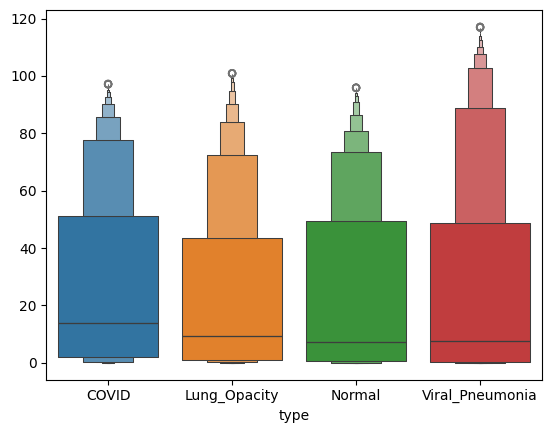

In [177]:
sns.boxenplot(moyenne)